In [58]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [59]:
dataset = 'model/keypoint_classifier/keypoint.csv' # Dataset to where the keypoints are
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras' # Last model saved path, changed to .keras due to newer versions of tensorflow
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite' # tflite path

# Set number of classes

In [60]:
NUM_CLASSES = 6 # 6 classes to classify in the dataset now since we added data

# Dataset reading

In [61]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1))) # Specifies which columns to load with useCols, load 1 to 42

In [62]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0)) # Just load the first column which is what class it is

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED) # Split it into training and testing data with scikit learn

# Model building

In [64]:
model = tf.keras.models.Sequential([ # Simple feed forward neural network
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4), # Dropout layers to prevent overfitting
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [65]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 42)                0         
                                                                 
 dense_9 (Dense)             (None, 20)                860       
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                210       
                                                                 
 dense_11 (Dense)            (None, 6)                 66        
                                                                 
Total params: 1136 (4.44 KB)
Trainable params: 1136 (4.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [66]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False) # Changed the model save path here to .keras, .hdf5 is for older versions of TF
# Callback for early stopping, stop if the performance doesn't improve after 20 epochs
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [67]:
# Model compilation
model.compile(
    optimizer='adam', # Adam optimization
    loss='sparse_categorical_crossentropy', # Loss function
    metrics=['accuracy'] # Use accuracy to track how we're doing
)

# Model training

In [68]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
25/39 [==================>...........] - ETA: 0s - loss: 1.7919 - accuracy: 0.2056 
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
39/39 [==============================] - 1s 10ms/step - loss: 1.7535 - accuracy: 0.2261 - val_loss: 1.6202 - val_accuracy: 0.3628
Epoch 2/1000
22/39 [===============>..............] - ETA: 0s - loss: 1.6323 - accuracy: 0.3153
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
39/39 [==============================] - 0s 6ms/step - loss: 1.6098 - accuracy: 0.3273 - val_loss: 1.5111 - val_accuracy: 0.4184
Epoch 3/1000
34/39 [=========================>....] - ETA: 0s - loss: 1.5218 - accuracy: 0.3745
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
39/39 [==============================] - 0s 6ms/step - loss: 1.5156 - accuracy: 0.3769 - val_loss: 1.3847 - val_accuracy: 0.5357
Epoch 4/1000
21/39 [===============>..............] - ETA: 0s - loss: 1.4340 - accuracy: 0.4

In [69]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

13/13 [==============================] - 0s 2ms/step - loss: 0.2986 - accuracy: 0.9377


In [70]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [71]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 66ms/step
[1.2398582e-01 5.5896401e-02 5.0339458e-04 8.1748873e-01 2.6020138e-05
 2.0996579e-03]
3


# Confusion matrix

52/52 [==============================] - 0s 1ms/step


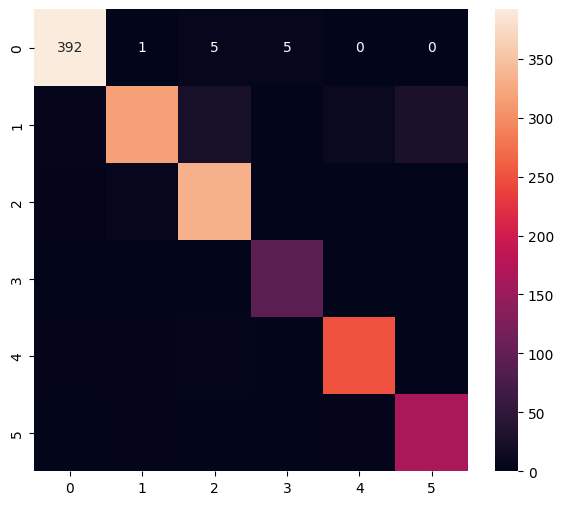

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       403
           1       0.96      0.82      0.89       385
           2       0.91      0.98      0.94       341
           3       0.94      1.00      0.97        93
           4       0.95      0.97      0.96       260
           5       0.85      0.97      0.90       172

    accuracy                           0.94      1654
   macro avg       0.93      0.95      0.94      1654
weighted avg       0.94      0.94      0.94      1654



In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [73]:
# Save as a model dedicated to inference
model.save("model/keypoint_classifier/keypoint_classifier.keras")

In [79]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

OSError: SavedModel file does not exist at: saved_model//{saved_model.pbtxt|saved_model.pb}

# Inference test

In [74]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [75]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [76]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [77]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 56 µs, sys: 12 µs, total: 68 µs
Wall time: 83 µs


In [78]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[8.6869434e-02 1.0296515e-02 3.2625672e-07 9.0283370e-01]
3
